# CAICT 風機結冰預測 - Data Exploration 


** second key factor **

** 2017/08/08 **   
http://www.industrial-bigdata.com/competition/competitionAction!showDetail.action?competition.competitionId=1

In [6]:
from IPython.display import HTML
HTML('''<script>
presentation = 0;
code_show=true; 
function code_toggle() {
 if (!presentation){
     return;
 }
 if (code_show){
 $('div.input').hide();
 } else {
 $('div.input').show();
 }
 code_show = !code_show
} 
$( document ).ready(code_toggle);
</script>
<form action="javascript:code_toggle()"><input type="submit" value="Click here to toggle on/off the raw code."></form>
''')


<a id='home'></a>
### Outline
[1. Modules](#load)  
[2. Input Data](#input)  
[3. Single Variable Exploration](#single)    
[4. Multi-Variable Exploration](#multi)
[5. dimension reduction](#dimen)

In [15]:
%matplotlib inline
import sys
import os
import datetime
import pandas as pd
import numpy as np
import lzma
import pickle
import shutil
import csv
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import seaborn as sns
import scipy.stats as stats
import pylab
from pylab import *
import plastid
import warnings
from collections import OrderedDict
from PIL import Image

from IPython.core.interactiveshell import InteractiveShell
from IPython.display import display
from IPython.display import HTML

from scipy.stats import spearmanr
from scipy.stats import pearsonr
from sklearn import preprocessing
import sklearn


import xgboost as xgb
warnings.filterwarnings('ignore')

pd.set_option('display.max_columns', None)
InteractiveShell.ast_node_interactivity = "all"

In [8]:
def StandardScaler(data):
    standard_scaler = preprocessing.StandardScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled

def MinMaxScaler(data):
    standard_scaler = preprocessing.MinMaxScaler()
    data_scaled = standard_scaler.fit_transform(data)
    data_scaled = pd.DataFrame(data_scaled, columns = data.columns)
    return data_scaled


def load_resample_data(mid, policy=1,  ycol='power'):
    filename = 'data/resample_data_p{POLICY}_{ID}.csv'.format(ID=mid,POLICY=policy)
    print('load file:',filename)
    data_resample = pd.read_csv(filename)
    data_resample['label']=data_resample['label'].fillna(2)

    data_X = data_resample.drop(['label','time','group','timestamp','event'], axis=1)
    data_y = data_resample[ycol]
    data_Y = np.eye(data_y.unique().size)[data_y.values.astype(int)]
    return data_resample, data_X, data_Y, data_y


def load_expo_data(mid=15,policy=0):
    non_data_cols = ['label','time','group','timestamp','event']
    data_raw, data_X, _, _ = load_resample_data(mid=mid,policy=policy)
    data_scaled = MinMaxScaler(data_X)
    for col in non_data_cols:
        data_scaled[col] = data_raw[col]
    return data_raw,data_scaled


<a id='input'></a>
** Input Data **  
data resample policy
- policy=0: no resample
- policy=1: event data + normal data (before and after event )
- policy=2: half event data + normal data (before event only)  
- policy=3: event data + normal data (before event only) 
- policy=4: event data + 2*normal data (before event only) 

In [9]:
_, dat_scaled_M15 = load_expo_data(mid=15,policy=0)
#_, dat_scaled_M15 = load_expo_data(mid=15,policy=4)

#dat_scaled_M15_Complete, _ = add_feature_windspeed(dat_scaled_M15_Complete)
#dat_scaled_M15, _ = add_feature_windspeed(dat_scaled_M15)


load file: data/resample_data_p0_15.csv


** Exploration **
- Training Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 0 
  - pass data only
- Prediction Data: data_scaled_M15
  - M15
  - scaled
  - resample policy: 4  
  
  
- for each event
    - feature trend chart
    - scatter plot
    - power prediction trend chart
    - motospeed prediction trend chart
    - feature selection by RFE

** 1. Power vs Wind_speed Scatter **

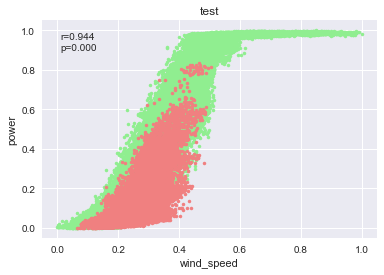

In [11]:
data_pass= dat_scaled_M15[dat_scaled_M15['label']==0]
data_fail= dat_scaled_M15[dat_scaled_M15['label']==1]

x='wind_speed'
y='power'

r, p = pearsonr(data_pass[x],data_pass[y])
raw_clr = 'lightgreen' if r>0.5 else 'darkgray'

data_visual = data_pass[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color=raw_clr)

data_visual = data_fail[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color='lightcoral')

msg = 'r={corr:.3f}\np={pval:.3f}'.format(corr=r, pval=p)
plt.text(0.01,0.9,msg)
plt.xlabel(x)
plt.ylabel(y)
plt.show(y)

** 2. Predict Power by wind_speed **

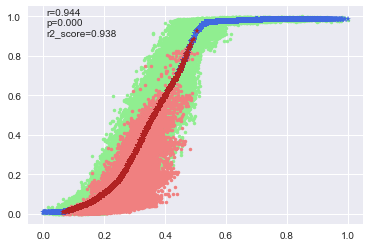

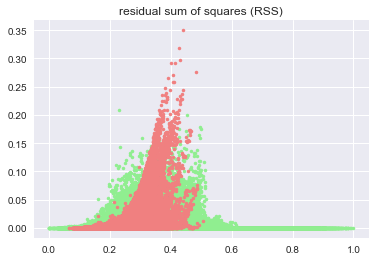

In [17]:
data_model = dat_scaled_M15[['power', 'wind_speed','label']].copy()
addition_cols =[]
for i in range(2,4):  #power of 1 is already there
    colname = 'wind_speed_%d'%i      #new var will be x_power
    data_model[colname] = data_model['wind_speed']**i
    addition_cols.append(colname)

data_pass= data_model[data_model['label']==0]
data_fail= data_model[data_model['label']==1]


x='wind_speed'
y='power'

r, p = pearsonr(data_pass[x],data_pass[y])
raw_clr = 'lightgreen' if r>0.5 else 'darkgray'

model = xgb.XGBRegressor()
X = ['wind_speed']+addition_cols

model = model.fit(data_model[X],data_model[y])
y_pred_p = model.predict(data_pass[X])
y_pred_f = model.predict(data_fail[X])
r2_p = sklearn.metrics.r2_score(data_pass[y],y_pred_p)
r2_f = sklearn.metrics.r2_score(data_fail[y],y_pred_f)
#pred_clr = 'firebrick' if r2_p > 0.8 else 'royalblue'

data_visual = data_pass[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color=raw_clr)

data_visual = data_fail[[y, x]]
plt.plot(data_visual[x],data_visual[y],'.', color='lightcoral')

plt.plot(data_pass[x],y_pred_p,'*', color='royalblue')
plt.plot(data_fail[x],y_pred_f,'*', color='firebrick')

msg = 'r={corr:.3f}\np={pval:.3f}\nr2_score={r2:.3f}'.format(corr=r, pval=p,r2=r2_p)
plt.text(0.01,0.9,msg)
plt.show()

rss_p = (data_pass[y] - y_pred_p)**2
rss_f = (data_fail[y] - y_pred_f)**2
plt.plot(data_pass[x],rss_p,'.', color='lightgreen')
plt.plot(data_fail[x],rss_f,'.', color='lightcoral')
plt.title('residual sum of squares (RSS) - {x}'.format(x=x))
plt.show()

** 3. RSS vs. all other factor **

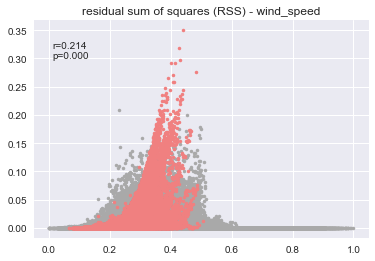

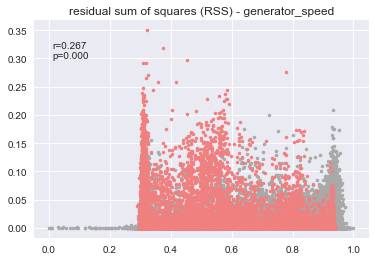

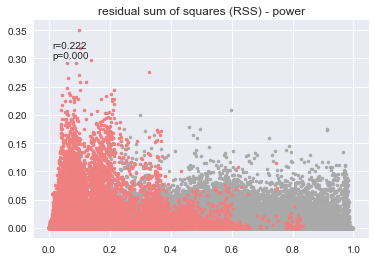

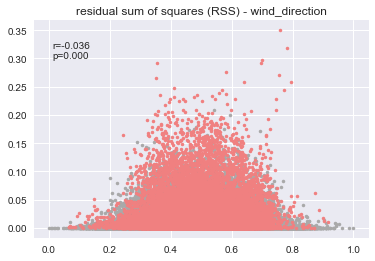

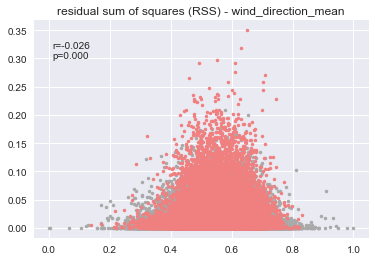

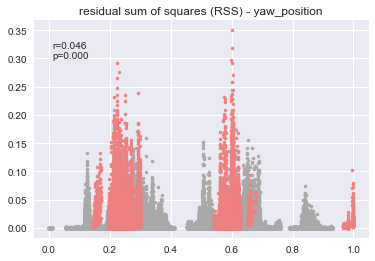

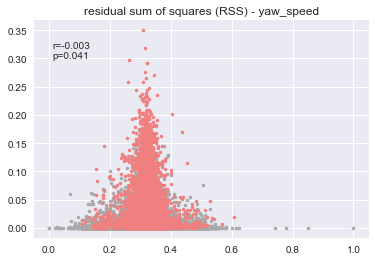

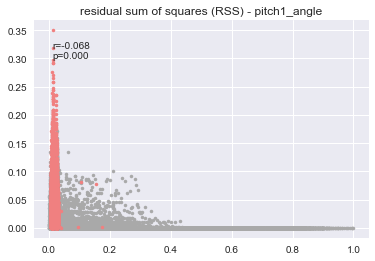

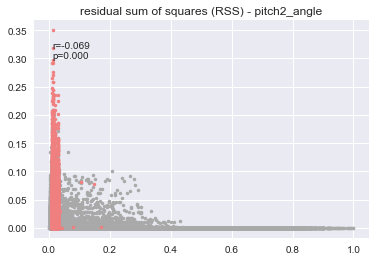

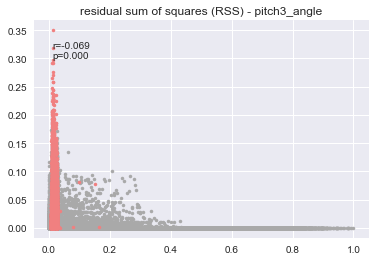

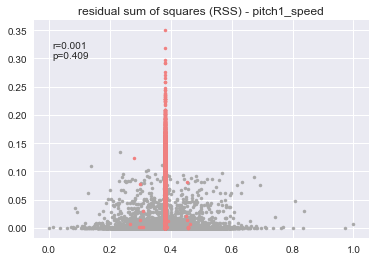

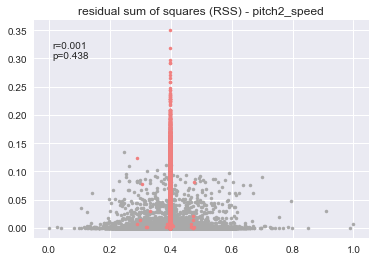

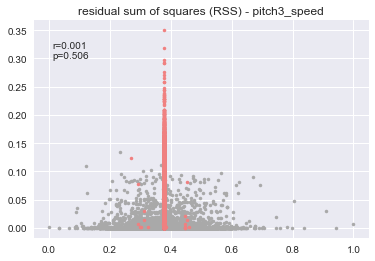

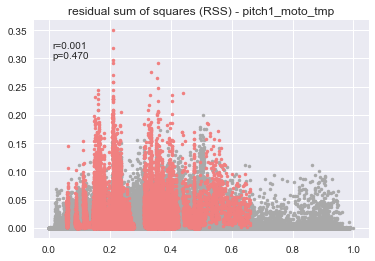

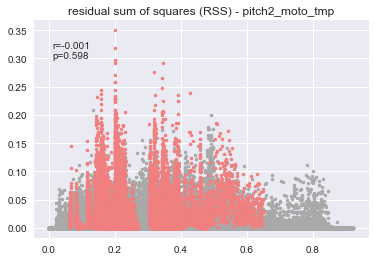

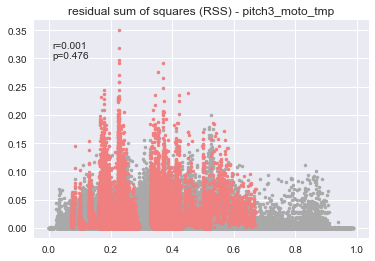

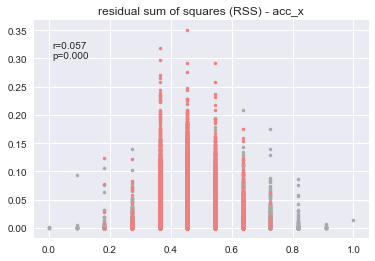

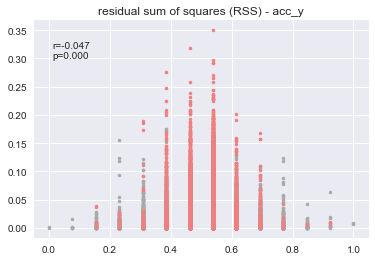

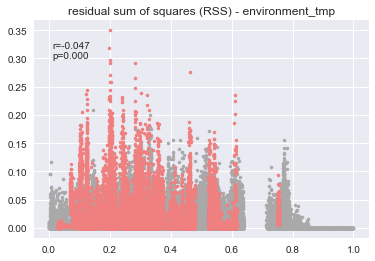

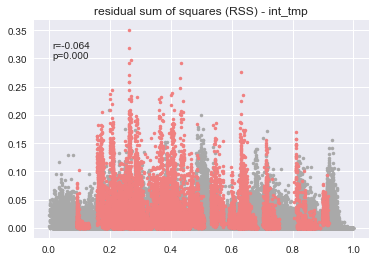

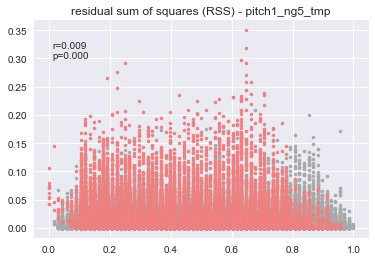

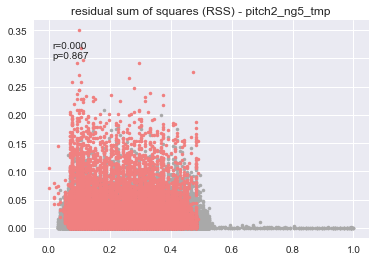

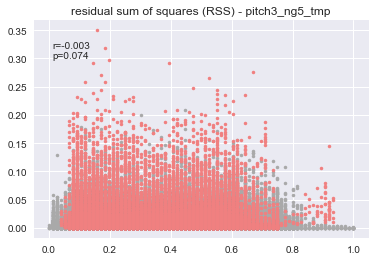

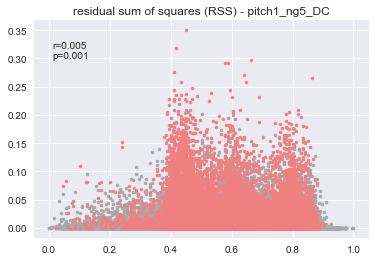

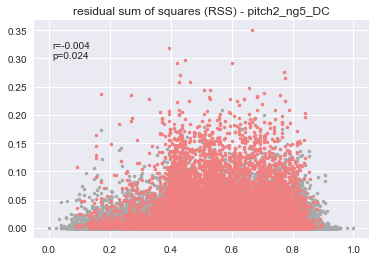

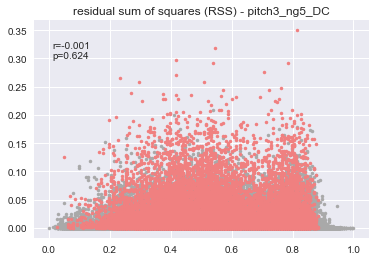

,corr,var
1,0.267246,generator_speed
2,0.222321,power
0,0.213868,wind_speed
16,0.057464,acc_x
5,0.045933,yaw_position
20,0.009018,pitch1_ng5_tmp
23,0.005471,pitch1_ng5_DC
10,0.001394,pitch1_speed
11,0.001312,pitch2_speed
13,0.001220,pitch1_moto_tmp


In [38]:
data_pass= dat_scaled_M15[dat_scaled_M15['label']==0]
data_fail= dat_scaled_M15[dat_scaled_M15['label']==1]

cols = dat_scaled_M15.columns
non_data_cols = ['label','time','group','timestamp','event']
corr_lst = []
var_lst = []
for x in cols:
    if x in non_data_cols:
        continue
    var_lst.append(x)
    r, p = pearsonr(data_pass[x],rss_p)
    corr_lst.append(r)
    raw_clr = 'lightgreen' if r>0.5 else 'darkgray'
    msg = 'r={corr:.3f}\np={pval:.3f}'.format(corr=r, pval=p)
    plt.text(0.01,0.30,msg)
    plt.plot(data_pass[x],rss_p,'.', color=raw_clr)
    plt.plot(data_fail[x],rss_f,'.', color='lightcoral')
    plt.title('residual sum of squares (RSS) - {x}'.format(x=x))
    plt.show()

corr_df = pd.DataFrame({'var':var_lst,'corr':corr_lst})
corr_df.sort_values('corr',ascending=False)

** Observation & Modification **

預測理論Power時可能會有的問題：
- generator speed和power變化正相關, 如果feature裡面有 generator speed, regressor會直接用generator預測power
- 風機開始結冰時, Power會開始下降, 假設結冰時各種溫度也隨之下降, 如果feature裡面有溫度, regressor會用溫度預測power